starting matching


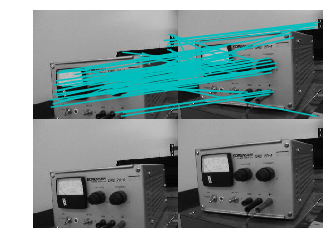

In [4]:
from scipy.ndimage import filters
from matplotlib import pyplot as plt
from PIL import Image
import numpy as np


def compute_harris_response(im,sigma=3):
      """ Compute the Harris corner detector response function
      for each pixel in a graylevel image. """
      # derivatives
      imx = np.zeros(im.shape)
      filters.gaussian_filter(im, (sigma,sigma), (0,1), imx)
      imy = np.zeros(im.shape)
      filters.gaussian_filter(im, (sigma,sigma), (1,0), imy)
      # compute components of the Harris matrix
      Wxx = filters.gaussian_filter(imx*imx,sigma)
      Wxy = filters.gaussian_filter(imx*imy,sigma)
      Wyy = filters.gaussian_filter(imy*imy,sigma)
      # determinant and trace
      Wdet = Wxx*Wyy - Wxy**2
      Wtr = Wxx + Wyy
      return Wdet / Wtr

def get_harris_points(harrisim,min_dist=10,threshold=0.1):
      """ Return corners from a Harris response image
      min_dist is the minimum number of pixels separating
      corners and image boundary. """
      # find top corner candidates above a threshold
      corner_threshold = harrisim.max() * threshold
      harrisim_t = (harrisim > corner_threshold) * 1
      # get coordinates of candidates
      coords = np.array(harrisim_t.nonzero()).T
      # ...and their values
      candidate_values = [harrisim[c[0],c[1]] for c in coords]
      # sort candidates
      index = np.argsort(candidate_values)
      # store allowed point locations in array
      allowed_locations = np.zeros(harrisim.shape)
      allowed_locations[min_dist:-min_dist,min_dist:-min_dist] = 1
      # select the best points taking min_distance into account
      filtered_coords = []
      for i in index:
            if allowed_locations[coords[i,0],coords[i,1]] == 1:
                  filtered_coords.append(coords[i])
                  allowed_locations[(coords[i,0]-min_dist):(coords[i,0]+\
                                    min_dist),(coords[i,1]-min_dist):\
                                    (coords[i,1]+min_dist)] = 0
      return filtered_coords

def plot_harris_points(image,filtered_coords):
      """ Plots corners found in image. """
      plt.figure()
      plt.gray()
      plt.imshow(image)
      plt.plot([p[1] for p in filtered_coords],\
               [p[0] for p in filtered_coords],'*')
      plt.axis('off')
      plt.show()







def get_descriptors(image,filtered_coords,wid=5):
      """ For each point return, pixel values around the point
      using a neighbourhood of width 2*wid+1. (Assume points are
      extracted with min_distance > wid). """
      desc = []
      for coords in filtered_coords:
            patch = image[coords[0]-wid:coords[0]+wid+1,
                          coords[1]-wid:coords[1]+wid+1].flatten()
            desc.append(patch)
      return desc

def match(desc1,desc2,threshold=0.5):
      """ For each corner point descriptor in the first image,
      select its match to second image using
      normalized cross-correlation. """
      n = len(desc1[0])
      # pair-wise distances
      d = -np.ones((len(desc1),len(desc2)))
      for i in range(len(desc1)):
            for j in range(len(desc2)):
                  d1 = (desc1[i] - np.mean(desc1[i])) / np.std(desc1[i])
                  d2 = (desc2[j] - np.mean(desc2[j])) / np.std(desc2[j])
                  ncc_value = sum(d1 * d2) / (n-1)
                  if ncc_value > threshold:
                        d[i,j] = ncc_value
      ndx = np.argsort(-d)
      matchscores = ndx[:,0]
      return matchscores

def match_twosided(desc1,desc2,threshold=0.5):
      """ Two-sided symmetric version of match(). """
      matches_12 = match(desc1,desc2,threshold)
      matches_21 = match(desc2,desc1,threshold)
      ndx_12 = np.where(matches_12 >= 0)[0]
      # remove matches that are not symmetric
      for n in ndx_12:
            if matches_21[matches_12[n]] != n:
                  matches_12[n] = -1
      return matches_12










def appendimages(im1,im2):
      """ Return a new image that appends the two images side-by-side. """
      
      # select the image with the fewest rows and fill in enough empty rows
      rows1 = im1.shape[0]
      rows2 = im2.shape[0]
      
      if rows1 < rows2:
            im1 = np.concatenate((im1,np.zeros((rows2-rows1,im1.shape[1]))),\
                                 axis=0)
      elif rows1 > rows2:
            im2 = np.concatenate((im2,np.zeros((rows1-rows2,im2.shape[1]))),\
                                 axis=0)
      # if none of these cases they are equal, no filling needed.
      
      return np.concatenate((im1,im2), axis=1)

def plot_matches(im1,im2,locs1,locs2,matchscores,show_below=True):
      """ Show a figure with lines joining the accepted matches
      input: im1,im2 (images as arrays), locs1,locs2 (feature locations),
      matchscores (as output from 'match()'),
      show_below (if images should be shown below matches). """
      
      im3 = appendimages(im1,im2)
      if show_below:
            im3 = np.vstack((im3,im3))
      plt.imshow(im3)
      
      cols1 = im1.shape[1]
      for i,m in enumerate(matchscores):
            if m>0:
                  plt.plot([locs1[i][1],locs2[m][1]+cols1],[locs1[i][0],
                            locs2[m][0]],'c')
      plt.axis('off')



im1 = np.array(Image.open('Data/test000.jpg').convert('L'))
im2 = np.array(Image.open('Data/test012.jpg').convert('L'))
   
wid = 5
harrisim = compute_harris_response(im1,5)
filtered_coords1 = get_harris_points(harrisim,wid+1)
d1 = get_descriptors(im1,filtered_coords1,wid)

harrisim = compute_harris_response(im2,5)
filtered_coords2 = get_harris_points(harrisim,wid+1)
d2 = get_descriptors(im2,filtered_coords2,wid)

print('starting matching')
matches = match_twosided(d1,d2)

plt.figure()
plt.gray()
plot_matches(im1,im2,filtered_coords1,filtered_coords2,matches)
plt.show()